In [1]:
import getdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import linregress



# General Data Prep

In [2]:
#Checking CSV dataframe and structure.
getdata.netflix_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [3]:
# Check Data for nulls and see if there are any duplicate show ID's

print(getdata.netflix_df.info())
getdata.netflix_df[getdata.netflix_df.duplicated(subset="id")]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score


In [4]:
# Create new dataframe for only show types and relevant info & Clean Data

show_type_df = getdata.netflix_df[['title',
 'type',
 'runtime',
 'seasons',
 'imdb_score',
 'imdb_votes',
 'tmdb_popularity',
 'tmdb_score']].copy()

# Data Cleaning
# Remove null row for Title.  Replace NaN for age_certification to Not Rated.  Then retest
show_type_df.dropna(subset="title",inplace=True)
show_type_df = show_type_df.fillna({"age_certification": "Not Rated"})

show_type_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5849 entries, 0 to 5849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            5849 non-null   object 
 1   type             5849 non-null   object 
 2   runtime          5849 non-null   int64  
 3   seasons          2106 non-null   float64
 4   imdb_score       5368 non-null   float64
 5   imdb_votes       5352 non-null   float64
 6   tmdb_popularity  5759 non-null   float64
 7   tmdb_score       5539 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 411.3+ KB


In [5]:
# Show structure of dataframe
show_type_df.head()

,title,type,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Five Came Back: The Reference Films,SHOW,51,1.0,NaN,NaN,0.600,NaN
1,Taxi Driver,MOVIE,114,NaN,8.2,808582.0,40.965,8.179
2,Deliverance,MOVIE,109,NaN,7.7,107673.0,10.010,7.300
3,Monty Python and the Holy Grail,MOVIE,91,NaN,8.2,534486.0,15.461,7.811
4,The Dirty Dozen,MOVIE,150,NaN,7.7,72662.0,20.398,7.600


# Movies vs TV Shows
From the entire Netflix catalog, are there more movies or TV series?

    type  title
0  MOVIE   3743
1   SHOW   2106


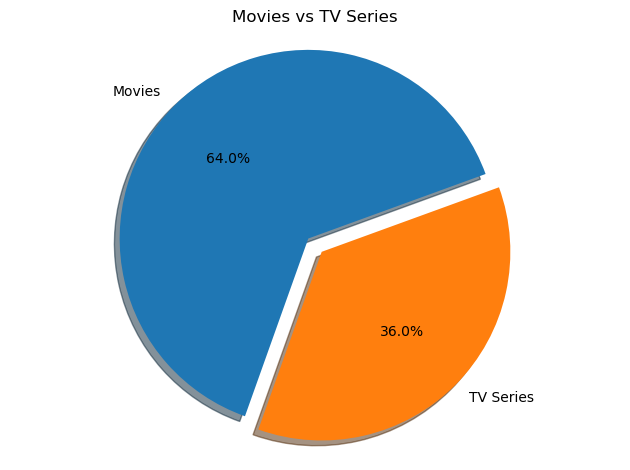

In [18]:
# Pie Chart - movies vs show
# Setup Dataframe
movie_show_df = pd.DataFrame(show_type_df.groupby(["type"])["title"].count()).reset_index()
print(movie_show_df.head())

# Setup and format chart
plt.pie(movie_show_df['title'], labels=["Movies", "TV Series"], autopct="%1.1f%%", startangle=20, explode = (0, .1), shadow=True)

plt.axis("equal")
plt.title("Movies vs TV Series")
plt.tight_layout()

# Generate & save chart
plt.savefig("output/Movies-vs-Series_Percent.png")
plt.show()

## Comparing Movies and TV Shows with IMDB & TMDB Ratings
Since the dataset has a different number of entries between movies and TV shows, I need to set the Y axis scale to something comparable.  Percent of all votes for each category made the most sense.  To do this, I set the chart to "density = True" and changed the Y axis tick values to reflect percentage.  This allows me to normalize the rusults so I can easily compare the relative distribution of values, even if the total number of datapoints differ between movies and TV shows.

In [7]:
# New dataframes that separate movies and shows for individual analysis, removing extra columns that are not applicable.

movies_df = show_type_df.loc[show_type_df["type"] == "MOVIE", :]
movies_df = movies_df.drop(columns=["type", "seasons"])

shows_df = show_type_df.loc[show_type_df["type"] == "SHOW", :]
shows_df = shows_df.drop(columns=["type"])
movies_df.head()

,title,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,Taxi Driver,114,8.2,808582.0,40.965,8.179
2,Deliverance,109,7.7,107673.0,10.010,7.300
3,Monty Python and the Holy Grail,91,8.2,534486.0,15.461,7.811
4,The Dirty Dozen,150,7.7,72662.0,20.398,7.600
6,Life of Brian,94,8.0,395024.0,17.770,7.800


In [8]:
shows_df.head()

,title,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Five Came Back: The Reference Films,51,1.0,NaN,NaN,0.600,NaN
5,Monty Python's Flying Circus,30,4.0,8.8,73424.0,17.617,8.306
26,Monty Python's Fliegender Zirkus,43,1.0,8.1,2151.0,1.487,7.000
35,Seinfeld,24,9.0,8.9,308824.0,130.213,8.301
44,Knight Rider,51,4.0,6.9,34115.0,50.267,7.500


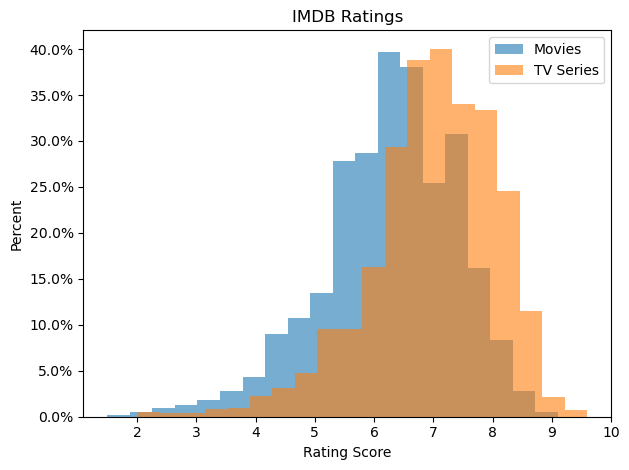

 ===  Movies:  IMDB  ===
count    3429.000000
mean        6.246748
std         1.127486
min         1.500000
25%         5.600000
50%         6.400000
75%         7.100000
max         9.100000
Name: imdb_score, dtype: float64

 ===  Shows:  IMDB  ===
count    1939.000000
mean        6.977927
std         1.077401
min         2.000000
25%         6.400000
50%         7.100000
75%         7.700000
max         9.600000
Name: imdb_score, dtype: float64


In [19]:
# Chart:  IMDB Ratings

# Set up the figure and axes
fig, ax = plt.subplots()
bins=20

plt.hist(movies_df["imdb_score"],alpha=.6, label="Movies", density=True, bins=bins)
plt.hist(shows_df["imdb_score"],alpha=.6, label="TV Series", density=True, bins=bins)

# Formatting Chart
plt.title("IMDB Ratings")
plt.xlabel("Rating Score")
plt.ylabel("Percent")
ax.yaxis.set_major_formatter(PercentFormatter(1))  # Set Y-axis ticks as percentages
plt.legend()
plt.tight_layout()

# Generate & save chart
plt.savefig("output/Movies-vs-Series_IMDB-Rating.png")
plt.show()


# Stat Report
print(" ===  Movies:  IMDB  ===")
print(movies_df["imdb_score"].describe())
print("")
print(" ===  Shows:  IMDB  ===")
print(shows_df["imdb_score"].describe())

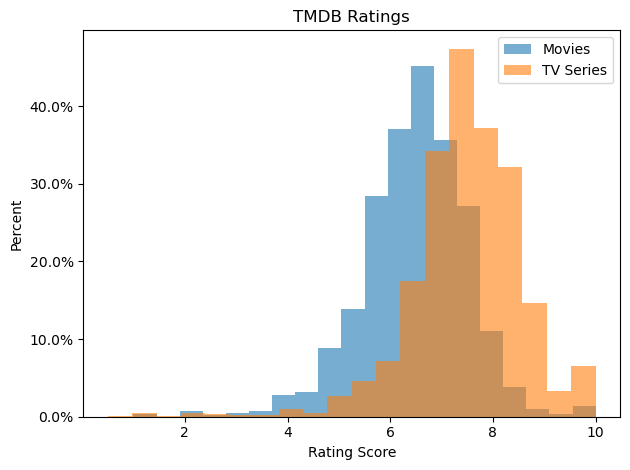

 ===  Movies:  TMDB  ===
count    3549.000000
mean        6.464012
std         1.043817
min         1.000000
25%         5.900000
50%         6.500000
75%         7.100000
max        10.000000
Name: tmdb_score, dtype: float64

 ===  Shows:  TMDB  ===
count    1990.000000
mean        7.480413
std         1.099177
min         0.500000
25%         7.000000
50%         7.500000
75%         8.100000
max        10.000000
Name: tmdb_score, dtype: float64


In [20]:
# Chart:  TMDB Ratings

# Set up the figure and axes
fig, ax = plt.subplots()
bins=20

plt.hist(movies_df["tmdb_score"],alpha=.6, label="Movies", density=True, bins=bins)
plt.hist(shows_df["tmdb_score"],alpha=.6, label="TV Series", density=True, bins=bins)

# Formatting Chart
plt.title("TMDB Ratings")
plt.xlabel("Rating Score")
plt.ylabel("Percent")
ax.yaxis.set_major_formatter(PercentFormatter(1))  # Set Y-axis ticks as percentages
plt.legend()
plt.tight_layout()

# Generate & save chart
plt.savefig("output/Movies-vs-Series_TMDB-Rating.png")
plt.show()


# Stat Report
print(" ===  Movies:  TMDB  ===")
print(movies_df["tmdb_score"].describe())
print("")
print(" ===  Shows:  TMDB  ===")
print(shows_df["tmdb_score"].describe())

### Remove bottom vote getters in IMDB score.
Movies and TV shows with very few IMDB votes may not accurately reflect true sentiment.  I chose to exclude the lowest 25% of votes for both movies and TV shows. This should be more representative of engaged audiences.  However, I chose to retained top votes as potential outliers, considering they tend to be representative of a strong audience reaction and therefore relevant to overall sentiment.

In [11]:
# IMDB Votes - Find Bottom Threshold (using 25% mark)

print(" ===  Movies:  IMDB Votes  ===")
print(movies_df["imdb_votes"].describe())
print("")
print(" ===  Shows:  IMDB Votes  ===")
print(shows_df["imdb_votes"].describe())

# Create DF of titles above a threshold of IMDB votes
movies_imdb_top_votes = movies_df.loc[movies_df["imdb_votes"] >= 560, :]
shows_imdb_top_votes = shows_df.loc[shows_df["imdb_votes"] >= 458, :]

 ===  Movies:  IMDB Votes  ===
count    3.413000e+03
mean     2.690938e+04
std      1.068378e+05
min      5.000000e+00
25%      5.600000e+02
50%      2.591000e+03
75%      1.154500e+04
max      2.294231e+06
Name: imdb_votes, dtype: float64

 ===  Shows:  IMDB Votes  ===
count    1.939000e+03
mean     1.733155e+04
std      7.208902e+04
min      5.000000e+00
25%      4.580000e+02
50%      1.766000e+03
75%      7.203500e+03
max      1.775990e+06
Name: imdb_votes, dtype: float64


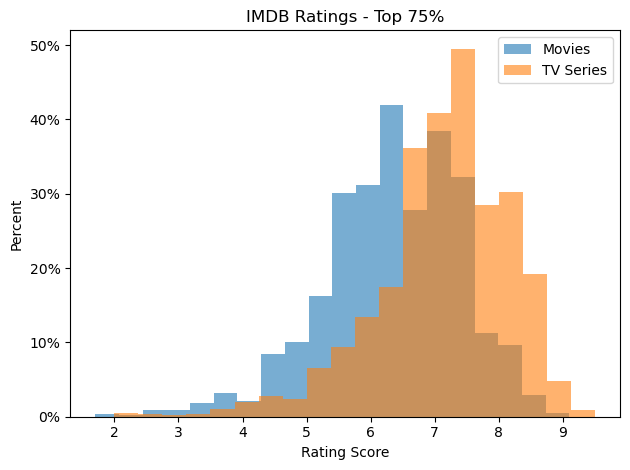

 ===  Movies:  IMDB  ===
count    2560.000000
mean        6.349805
std         1.073886
min         1.700000
25%         5.700000
50%         6.400000
75%         7.100000
max         9.100000
Name: imdb_score, dtype: float64

 ===  Shows:  IMDB  ===
count    1454.000000
mean        7.112861
std         1.040240
min         2.000000
25%         6.600000
50%         7.200000
75%         7.800000
max         9.500000
Name: imdb_score, dtype: float64


In [21]:
# Chart:  IMDB Ratings - Top 75%

# Set up the figure and axes
fig, ax = plt.subplots()
bins=20

plt.hist(movies_imdb_top_votes["imdb_score"],alpha=.6, label="Movies", density=True, bins=bins)
plt.hist(shows_imdb_top_votes["imdb_score"],alpha=.6, label="TV Series", density=True, bins=bins)

# Formatting Chart
plt.title("IMDB Ratings - Top 75%")
plt.xlabel("Rating Score")
plt.ylabel("Percent")
ax.yaxis.set_major_formatter(PercentFormatter(1))  # Set Y-axis ticks as percentages
plt.legend()
plt.tight_layout()

# Generate & save chart
plt.savefig("output/Movies-vs-Series_Top-IMDB-Rating.png")
plt.show()


# Stat Report
print(" ===  Movies:  IMDB  ===")
print(movies_imdb_top_votes["imdb_score"].describe())
print("")
print(" ===  Shows:  IMDB  ===")
print(shows_imdb_top_votes["imdb_score"].describe())

# Runtime

In [31]:
print(movies_imdb_top_votes["runtime"].min())
print(movies_imdb_top_votes["runtime"].max())

bins = [0, 74, 89, 104, 119, 134, 149, 250]
group_names = ["< 75",
               "75-89",
               "90-104",
               "105-119",
               "120-134",
               "135-149",
               "150 +"]


movies_imdb_top_votes.loc[:, "runtime_category"] = pd.cut(movies_imdb_top_votes["runtime"], bins, labels=group_names, include_lowest=True)
movies_imdb_top_votes.head()

movies_runtime = pd.DataFrame(movies_imdb_top_votes.groupby(["runtime_category"]).agg({"imdb_score":["count", "mean"] })).reset_index()
movies_runtime



2
224


C:\Users\travi\AppData\Local\Temp\ipykernel_9940\1164277932.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  movies_runtime = pd.DataFrame(movies_imdb_top_votes.groupby(["runtime_category"]).agg({"imdb_score":["count", "mean"] })).reset_index()


runtime_category imdb_score          
                        count      mean
0             < 75        256  6.663281
1            75-89        318  6.112264
2           90-104        843  6.090391
3          105-119        520  6.358654
4          120-134        300  6.604667
5          135-149        170  6.661176
6            150 +        153  6.872549

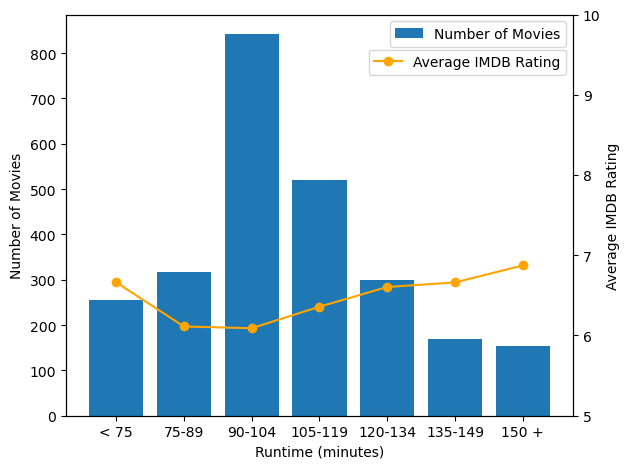

In [83]:
# Setup axis variables
x_axis = movies_runtime["runtime_category"]
y_axis_count = movies_runtime["imdb_score"]["count"]
y_axis_mean = movies_runtime["imdb_score"]["mean"]

# Set up dual axis - Bar for counts in each category & line for ratings per category
fig, ax1 = plt.subplots()
ax1.bar(x_axis, y_axis_count, label="Number of Movies")
ax2 = ax1.twinx()
ax2.plot(x_axis, y_axis_mean, color="orange", marker="o", label="Average IMDB Rating")

# Formatting Chart
ax1.set_ylabel('Number of Movies')
ax1.set_xlabel("Runtime (minutes)")
ax2.set_ylabel('Average IMDB Rating')
ax2.set_ylim(5, 10)
ax1.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, .93))

plt.tight_layout()


# Generate & save chart
plt.savefig("output/Movies_Runtime_IMDB-Rating.png")
plt.show()



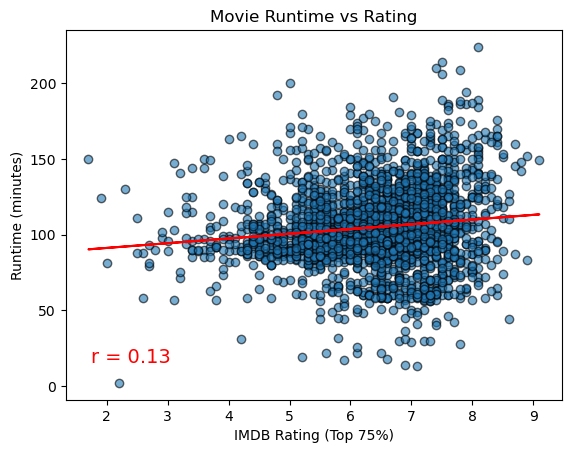

In [15]:
# Setup axes
x_axis = movies_imdb_top_votes["imdb_score"]
y_axis = movies_imdb_top_votes["runtime"]

# Linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept

rvalue_annotation = f"r = {round(rvalue, 2)}"

# Setup Chart
plt.scatter(x_axis, y_axis, edgecolors="black", alpha=.6)
plt.plot(x_axis, regress_values, color="red")

# Formatting Chart
plt.title("Movie Runtime vs Rating")
plt.xlabel("IMDB Rating (Top 75%)")
plt.ylabel("Runtime (minutes)")
plt.annotate(rvalue_annotation, xy=(0.05, 0.1), xycoords='axes fraction', color="red", fontsize=14)
plt.tight_layout

# Generate & save chart
plt.savefig("output/MovieRuntime-vs-Rating_Corrlation.png")
plt.show()
